# 简洁实现线性回归
:label:`sec_linear_concise`

在过去十年中，深度学习经历了一种寒武纪大爆发。
技术、应用和算法的数量远远超过了前几十年的进展。
这得益于多种因素的幸运结合，其中之一是多个开源深度学习框架提供的强大免费工具。
Theano :cite:`Bergstra.Breuleux.Bastien.ea.2010`、DistBelief :cite:`Dean.Corrado.Monga.ea.2012` 和 Caffe :cite:`Jia.Shelhamer.Donahue.ea.2014` 可以说是第一代被广泛采用的此类模型。
与早期（开创性）的工作如 SN2 (Simulateur Neuristique) :cite:`Bottou.Le-Cun.1988` 提供类似 Lisp 的编程体验相比，现代框架提供了自动微分和 Python 的便利性。
这些框架使我们能够自动化和模块化实现基于梯度的学习算法的重复工作。

在 :numref:`sec_linear_scratch` 中，我们仅依赖于
(i) 用于数据存储和线性代数的张量；
(ii) 用于计算梯度的自动微分。
实际上，因为数据迭代器、损失函数、优化器和神经网络层非常常见，现代库也为我们实现了这些组件。
在本节中，（**我们将展示如何使用深度学习框架的高级 API 来简洁地实现 :numref:`sec_linear_scratch` 中的线性回归模型**）。

In [1]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

## 定义模型

当我们从零开始实现线性回归
在 :numref:`sec_linear_scratch` 中，
我们明确地定义了模型参数
并使用基本的线性代数运算编写了生成输出的计算代码。
你应该知道如何做到这一点。
但是一旦你的模型变得更复杂，
并且一旦你几乎每天都需要这样做，
你会很高兴有工具来帮助你。
这种情况类似于从头开始编写自己的博客。
做一两次是值得的，也是有教育意义的，
但如果你花一个月的时间重新发明轮子，
那你就会成为一个糟糕的网页开发者。

对于标准操作，
我们可以[**使用框架预定义的层，**]
这让我们能够专注于
用于构建模型的层
而不是担心它们的实现。
回想下单层网络的架构
如 :numref:`fig_single_neuron` 所述。
该层被称为*全连接*层，
因为它的每个输入都通过矩阵-向量乘法
与每个输出相连。

在PyTorch中，全连接层定义在`Linear`和`LazyLinear`类中（自1.8.0版本起可用）。后者允许用户仅指定输出维度，而前者还需要指定输入到该层的输入数量。指定输入形状可能不方便，并且可能需要进行复杂的计算（例如在卷积层中）。因此，为了简化，我们将在可以的情况下使用这种“懒惰”层。

In [2]:
class LinearRegression(d2l.Module):  #@save
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

在 `forward` 方法中，我们只需调用预定义层的内置 `__call__` 方法来计算输出。

In [3]:
@d2l.add_to_class(LinearRegression)  #@save
def forward(self, X):
    return self.net(X)

## 定义损失函数

[**`MSELoss` 类计算均方误差（不包括 :eqref:`eq_mse` 中的 $1/2$ 系数）。**]
默认情况下，`MSELoss` 返回所有样本的平均损失。
它比我们自己实现更快（也更易于使用）。

In [4]:
@d2l.add_to_class(LinearRegression)  #@save
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

## 定义优化算法

Minibatch SGD 是优化神经网络的标准工具，因此 PyTorch 在 `optim` 模块中支持它以及该算法的许多变体。当我们（**实例化一个 `SGD` 实例**）时，我们指定要优化的参数，这些参数可以通过 `self.parameters()` 从我们的模型中获取，并且指定了我们的优化算法所需的 learning rate (`self.lr`)。

In [5]:
@d2l.add_to_class(LinearRegression)  #@save
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

## 训练

你可能已经注意到，通过深度学习框架的高级API来表达我们的模型所需的代码行数更少。我们不需要单独分配参数、定义损失函数或实现小批量随机梯度下降。当我们开始处理更复杂的模型时，高级API的优势将显著增加。

现在我们已经把所有基本部分都准备好了，
[**训练循环本身与我们从零开始实现的那个是一样的。**]
所以我们只需调用`fit`方法（在:numref:`oo-design-training`中介绍），该方法依赖于:numref:`sec_linear_scratch`中的`fit_epoch`方法的实现，来训练我们的模型。

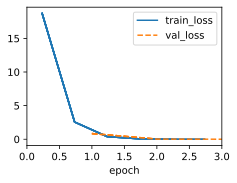

In [6]:
model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

在下面的内容中，我们
[**比较通过有限数据训练学习到的模型参数
和生成我们数据集的实际参数**]
为了访问参数，
我们需要访问相应层的权重和偏置。
正如我们在从零开始的实现中所做的一样，
请注意我们的估计参数
接近它们的真实值。

In [7]:
@d2l.add_to_class(LinearRegression)  #@save
def get_w_b(self):
    return (self.net.weight.data, self.net.bias.data)
w, b = model.get_w_b()

In [8]:
print(f'error in estimating w: {data.w - w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - b}')

error in estimating w: tensor([ 0.0039, -0.0168])
error in estimating b: tensor([0.0131])


## 摘要

本节包含了深度网络（在本书中）的第一个实现，利用了现代深度学习框架所提供的便利，如MXNet :cite:`Chen.Li.Li.ea.2015`、JAX :cite:`Frostig.Johnson.Leary.2018`、PyTorch :cite:`Paszke.Gross.Massa.ea.2019` 和 Tensorflow :cite:`Abadi.Barham.Chen.ea.2016`。我们使用了框架默认设置来加载数据、定义层、损失函数、优化器和训练循环。只要框架提供了所有必要的功能，通常建议使用它们，因为这些组件的库实现往往经过了高度优化以提高性能，并且经过了充分测试以确保可靠性。同时，不要忘记这些模块*可以*直接实现。对于希望走在模型开发前沿的有志研究者来说，这一点尤为重要，因为你将发明当前任何库中都不存在的新组件。

在PyTorch中，`data`模块提供了数据处理的工具，`nn`模块定义了大量的神经网络层和常见的损失函数。我们可以通过使用以 `_` 结尾的方法替换它们的值来初始化参数。需要注意的是，我们必须指定网络的输入维度。虽然这现在看起来微不足道，但当我们想要设计具有多层的复杂网络时，它可能会产生重大的连锁效应。为了使这些网络具有可移植性，需要仔细考虑如何参数化这些网络。

## 练习

1. 如果你将小批量的总损失替换为小批量损失的平均值，你需要如何调整学习率？
1. 查看框架文档以了解提供了哪些损失函数。特别是，将平方损失替换为Huber的鲁棒损失函数。也就是说，使用损失函数
   $$l(y,y') = \begin{cases}|y-y'| -\frac{\sigma}{2} & \textrm{ if } |y-y'| > \sigma \\ \frac{1}{2 \sigma} (y-y')^2 & \textrm{ otherwise}\end{cases}$$
1. 你如何访问模型权重的梯度？
1. 如果改变学习率和迭代次数，对解有什么影响？它是否会持续改进？
1. 当你改变生成的数据量时，解会如何变化？
    1. 将估计误差$\hat{\mathbf{w}} - \mathbf{w}$ 和 $\hat{b} - b$作为数据量的函数绘制出来。提示：以对数方式而不是线性方式增加数据量，即5, 10, 20, 50, ..., 10,000而不是1000, 2000, ..., 10,000。
    2. 提示中的建议为什么是合适的？

[讨论](https://discuss.d2l.ai/t/45)